# Vision por Computador 2: Trabajo Final

Alumno: Maxim Dorogov

# Objetivo

  El objetivo de este trabajo es entrenar una red convolucional con el fin de clasificar radiografias de torax tomadas a pacientes con neumonia, covid19 y pacientes sin patologias. 
  En este trabajo se pretende: 

1.   Realizar un analisis exploratorio del dataset para analizar la necesidad de aplicar o no tecnicas de data augmentation, y de ser necesario data cleaning u otro pre-procesamiento.
2.   Modificar la topologia de una red neuronal existente y reentrenarla mediante transfer learning para resolver un problema de clasificacion de 3 clases de radiografias (paciente sano, con neumonia y con covid-19). 
3. Presentar y analizar las metricas del modelo.
4. Visualizar las capas intermedias para inferir en las caracteristicas que una red neuronal toma como relevantes al momento del aprendizaje.



In [3]:
# bibliotecas a utilizar
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import img_to_array
from mlxtend.preprocessing import one_hot, TransactionEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from skimage import exposure
import cv2
import glob

# Dataset

El dataset fue descargado de [Mendeley](https://data.mendeley.com/datasets/fvk7h5dg2p/1) y consiste en 603  radiografias (imagenes en escala de grises) de torax divididas en 234 pacientes sanos, 221 con covid-19 y 148 con neumonia. 




In [15]:
# descargamos el dataset
dataroot = "dataroot/"
!mkdir dataroot 
!wget -P dataroot https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/fvk7h5dg2p-1.zip

mkdir: cannot create directory ‘dataroot’: File exists
--2021-09-02 02:08:55--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/fvk7h5dg2p-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.0.168
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.0.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198985388 (190M) [application/octet-stream]
Saving to: ‘dataroot/fvk7h5dg2p-1.zip.1’

fvk7h5dg2p-1.zip.1  100%[===================>] 189.77M  66.5MB/s    in 2.9s    

2021-09-02 02:08:58 (66.5 MB/s) - ‘dataroot/fvk7h5dg2p-1.zip.1’ saved [198985388/198985388]



In [16]:
# Unzip
import zipfile
with zipfile.ZipFile(dataroot+"fvk7h5dg2p-1.zip","r") as zip_ref: zip_ref.extractall(dataroot)

El directorio presenta la siguiente estructura:

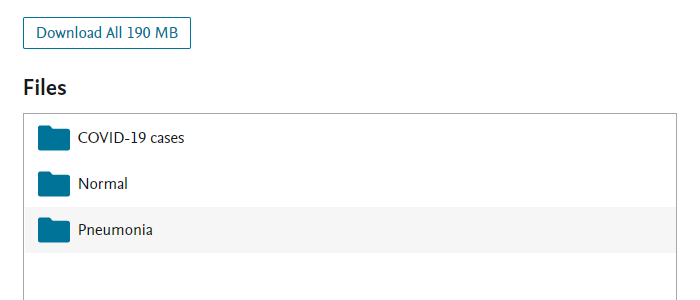

Cargamos todas las imagenes a memoria. En la data las imagenes y en target la clase a la cual pertenece. Se asignaron los labels 0, 1 y 2 a covid19, neumonia y sano respectivamente.

In [4]:
data = []

target = []
target_tag = np.array([0, 1, 2])
folder_class = ["COVID-19 cases", "Pneumonia", "Normal "]

for i in range(len(folder_class)):

  for j, dir in enumerate(glob.glob('/content/dataroot/'+folder_class[i]+'/**', recursive=True)):

      data.append(cv2.imread(dir))
      target.append(target_tag[i])

  print(folder_class[i] + ': ' + str(j))


COVID-19 cases: 221
Pneumonia: 148
Normal : 234


# Analisis del dataset

Al momento de visualizar las imagenes se detectó que algunas no fueron cargadas de manera correcta debido a un formato desconocido o por estar corrompidas. Se procede a descartar todos los elementos 'None'.

In [6]:
for j, image in enumerate(data):
  if image is None:
    data.pop(j)
    target.pop(j)

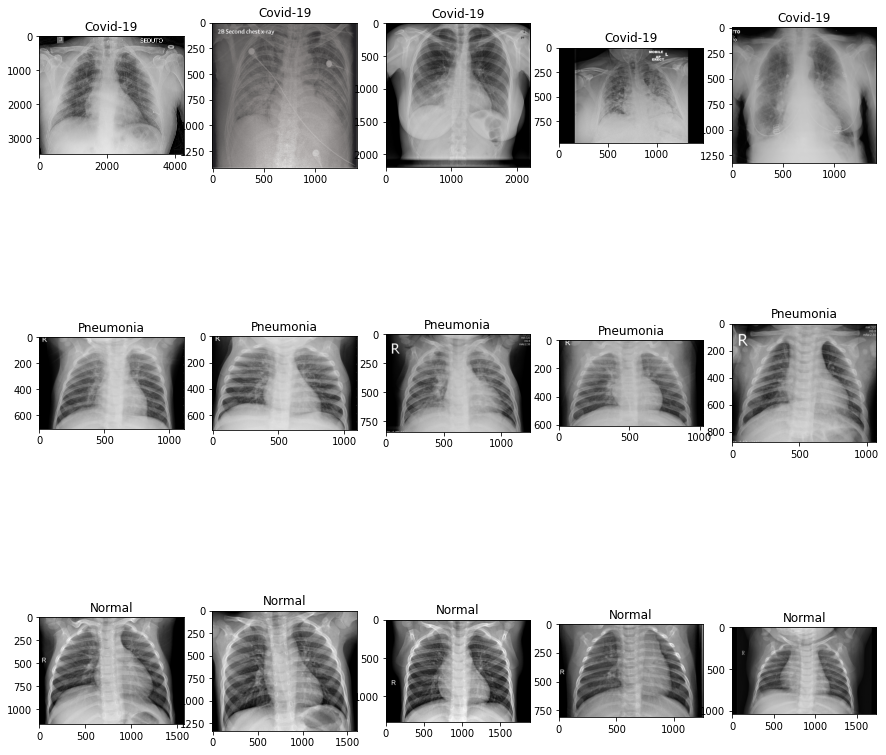

In [19]:
COVID_OFFSET = 0
PNEUMONIA_OFFSET = 221
NORMAL_OFFSET = 369
IMGS_TO_SHOW = 5
plt_index = 1

plt.figure(figsize=(15,15))

for i in range(IMGS_TO_SHOW):

  plt.subplot(3, IMGS_TO_SHOW, plt_index)
  plt.title("Covid-19")
  plt.imshow(data[i + COVID_OFFSET],  cmap = 'gray')
  plt_index += 1

for i in range(IMGS_TO_SHOW):

  plt.subplot(3, IMGS_TO_SHOW, plt_index)
  plt.title("Pneumonia")
  plt.imshow(data[i + PNEUMONIA_OFFSET],  cmap = 'gray')
  plt_index += 1

for i in range(IMGS_TO_SHOW):

  plt.subplot(3, IMGS_TO_SHOW, plt_index)
  plt.title("Normal")
  plt.imshow(data[i + NORMAL_OFFSET],  cmap = 'gray')
  plt_index += 1

plt.show()

Se observa que las radiografias presentan distinta resolución y relacion de aspecto, incluso dentro de la misma clase. Como pre-procesamiento se aplicará un resize para llevar todas a una misma resolución. No se hará data augmentation para no alterar las imagenes ya que esto podria inducir a una mala generalizacion del modelo. Parte del diagnostico por radiografias consiste en mirar la intensidad o concentracion de blanco en determinadas zonas, alterar parametros tales como el brillo, o rotaciones llevaran al modelo a aprender patrones erroneos.  

# Preparacion de datos

Unificamos las dimensiones y transformamos las imagenes a una forma tensorial. Usamos one-hot encoding para las clases.*texto en cursiva* 


In [7]:
(SIZE_H, SIZE_W) = (260, 260)
tensor_data = []

for img in data:

  resized_data = cv2.resize(img, (SIZE_H, SIZE_W) )
  tensor_data.append(img_to_array(resized_data))

# one-hot encoding para las clases
target = one_hot(target)

# transformo lista de imagenes en tensor
tensor_data = np.array(tensor_data, dtype = "float32") / 255.0

Separamos en train y test 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(tensor_data, target, shuffle = True, test_size=0.2, random_state=1)

# Arquitectura del clasificador y preparacion del modelo







In [9]:
from tensorflow.keras import optimizers, losses, activations, models, layers
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.applications import ResNet50, InceptionV3, VGG16

In [10]:
# Usamos InceptionV3 como backbone aprovechando el poder de generalizacion que nos brinda una red pre entrenada

base_model_a = InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(SIZE_H, SIZE_W, 3))

In [42]:
# agregamos capas fully connected que serán encargadas de realizar la calsificacion

model = models.Sequential()
model.add(base_model_a)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

# como loss function se utilizará categorical crossentropy dado que se tienen mas de dos clases

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten_4 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               18874624  
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 387       
Total params: 40,710,691
Trainable params: 40,676,259
Non-trainable params: 34,432
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# Entrenamiento

In [43]:
history = model.fit(
      X_train,
      y_train,
      batch_size = 16,
      epochs=15,
      verbose=True,
      validation_data = (X_test, y_test))

model.save('covid_classifier')

Epoch 1/15
31/31 [==============================] - 23s 516ms/step - loss: 0.9346 - accuracy: 0.5602 - val_loss: 0.9040 - val_accuracy: 0.5950
Epoch 2/15
31/31 [==============================] - 14s 464ms/step - loss: 0.4227 - accuracy: 0.8465 - val_loss: 0.9086 - val_accuracy: 0.6281
Epoch 3/15
31/31 [==============================] - 14s 463ms/step - loss: 0.2246 - accuracy: 0.9398 - val_loss: 0.5832 - val_accuracy: 0.7521
Epoch 4/15
31/31 [==============================] - 15s 473ms/step - loss: 0.1588 - accuracy: 0.9523 - val_loss: 0.5231 - val_accuracy: 0.7851
Epoch 5/15
31/31 [==============================] - 14s 464ms/step - loss: 0.1420 - accuracy: 0.9502 - val_loss: 0.6206 - val_accuracy: 0.7686
Epoch 6/15
31/31 [==============================] - 14s 464ms/step - loss: 0.1242 - accuracy: 0.9585 - val_loss: 0.4109 - val_accuracy: 0.8678
Epoch 7/15
31/31 [==============================] - 14s 462ms/step - loss: 0.0747 - accuracy: 0.9813 - val_loss: 0.3520 - val_accuracy: 0.9008

# Analisis de resultados

Metricas de entrenamiento

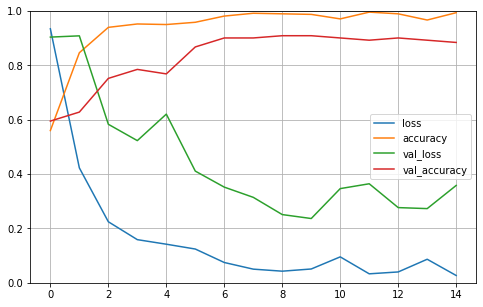

In [44]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Se observa que las curvas de accuracy y loss siguen una tendencia optima sin signos de overfitting. En una red Inception al existir filtros de diferentes tamaños en una misma capa se logra maximizar activaciones mediante features de diferente distribucion espacial reduciendo la probabilidad de overfitting.

Reporte de predicciones

In [45]:
predicted = model.predict(X_test)
predicted = np.round(predicted)

print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        46
           1       0.69      0.96      0.80        25
           2       0.95      0.78      0.86        50

   micro avg       0.88      0.88      0.88       121
   macro avg       0.87      0.90      0.87       121
weighted avg       0.91      0.88      0.89       121
 samples avg       0.88      0.88      0.88       121



El reporte de clasificacion fue consistente con los resultados obtenidos durante el entrenamiento. Se logró una precision superior al 95% para las clases que tenian mayor soporte en el dataset. La diferencia que se presenta para la clase 1 (Pneumonia) se atribuye a que habia una menor cantidad de muestras de la misma, lo cual perjudicó la performance del modelo.

# Visualizacion de activaciones intermedias


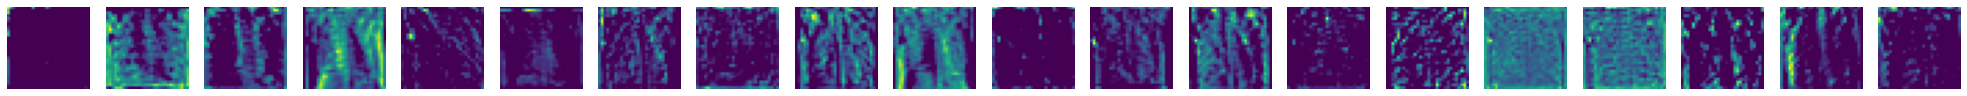

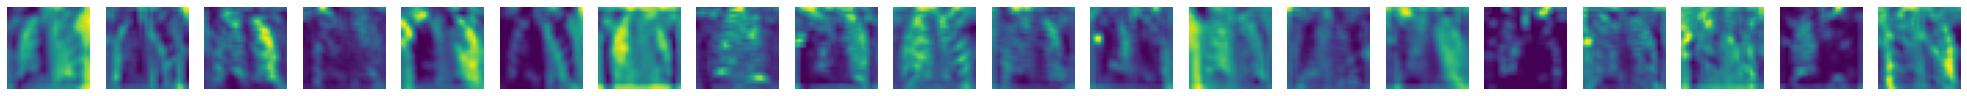

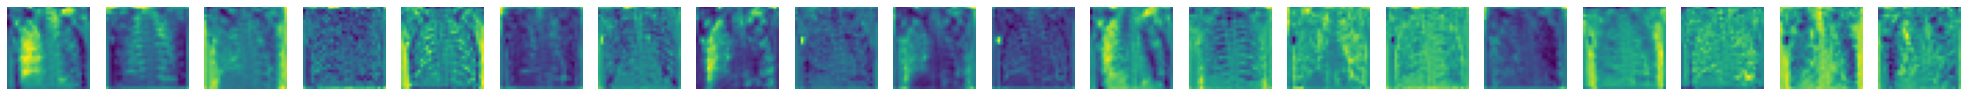

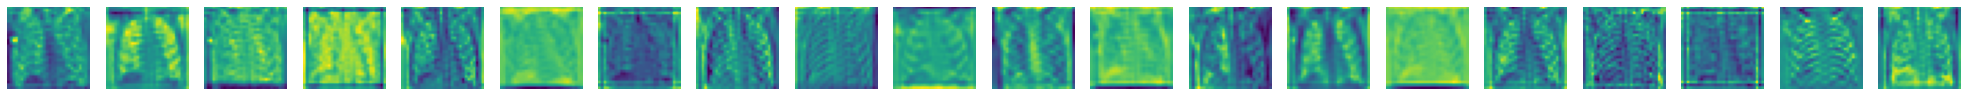

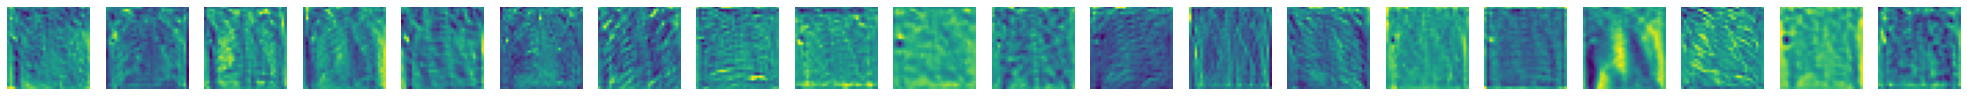

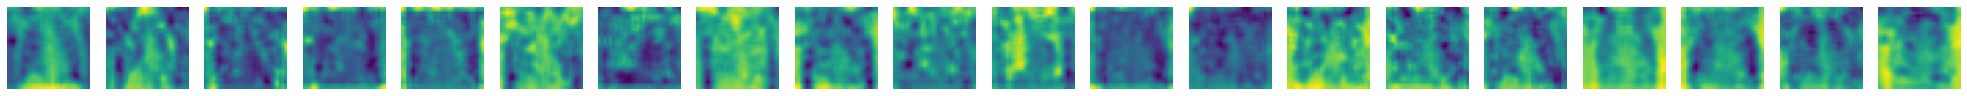

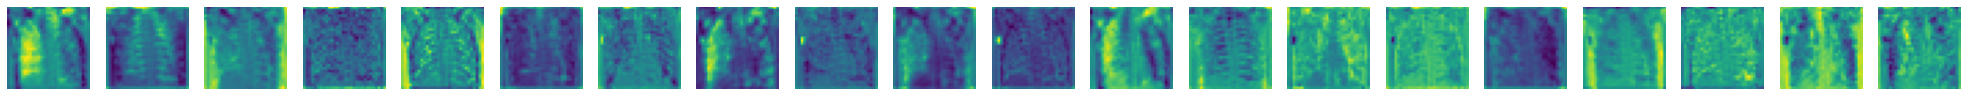

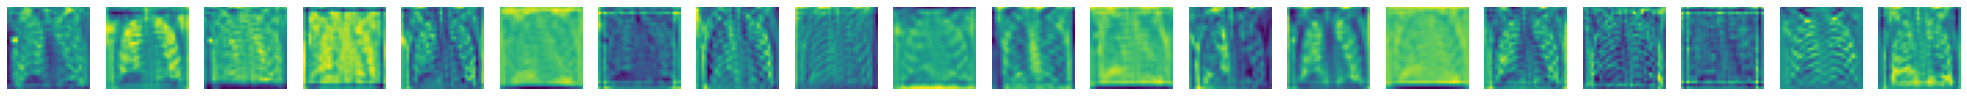

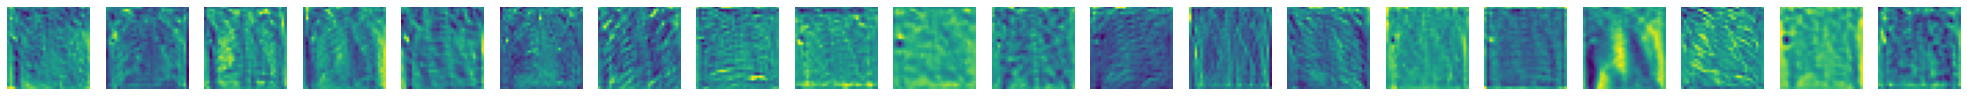

In [41]:
# Extraemos las salidas de todas las capas convolucionales del modelo
layer_outputs = [layer.output for layer in base_model_a.layers]

# Creo un modelo auxiliar que me va a devolver los valores de las capas de activacion para deteminada entrada
activation_model = models.Model(inputs=base_model_a.input, outputs=layer_outputs)

 # Propago una imagen del dataset por el modelo de activaciones
activations = activation_model.predict(X_test[:1])


# Me guardo los nombres de las capas para ponerle titulos a los graficos

layer_names = []
for layer in base_model_a.layers:
  layer_names.append(layer.name) 

# Recorro todas las activaciones convolucionales hasta llegar la 1ra capa fully connected

layer_idx = 0

for activation in activations[25:35]: 

  activ_shape = activation.shape  

  # Extraigo la ultima dimension (cantidad de elementos en el volumen)
  ndims = activ_shape[-1] 

  # para facilitar la representacion si la capa tiene mas de 20 canales visualizo solo los primeros 20

  if ndims > 20:
    ndims = 20

  if layer_idx:   
    plt.figure(figsize=(35, 35))

    for i in range(ndims):

      plt.subplot(1, ndims, i+1)
      plt.imshow(activation[0, :, :, i], cmap='viridis')
      plt.axis('off')
      #plt.title(layer_names[layer_idx])  

  layer_idx += 1
  plt.show()  

Podemos observar en la serie de imagenes que existen activaciones de alta intensidad y otras de muy baja, denotando el proceso de clasificacion que se realiza en la red. A su vez a medida que nos adentramos en las capas los patrones a interpretar se tornan cada vez mas abstractos.

# Conclusiones

Se logro entrenar de forma exitosa una red basada en la topologia InceptionV3 para clasificar radiografias de pecho. La performance del modelo fue satisfactoria con una ligera perdida en la precicion para la deteccion de neumonia debido al desbalance que presenta el dataset en esa clase. Se logro realizar una representacion de las capas intermedias para interpretar de una forma grafica que significa una activacion y que caracteristicas toma una red neuronal para el proceso de clasificacion.